# CCD spectrometer
## CCL$_4$: 
* ### Fit lines
* ### Ratio of intensities parallely and perpendicularly polarized equals degree of polarization $\rho_s$.

All counts are transformed to rates. 

Background is then subtracted, polarization is assumed to be horizontally (0 deg) 
and corrected for the corresponding term.

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi, k
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 620)
colors = ['b', 'r', 'g', 'darkmagenta', 'firebrick', 'cyan', 'orange', 'magenta', 'darkgoldenrod']

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def linear(x, a, b):
    return (a*x + b)

In [4]:
def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

In [5]:
def t_avg(filename):
    """
    Get integration time and number of measurements
    """
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
    return t, avg

## CCl4
* Get data for different polarizations of laser (w/ or w/out $\lambda$/2 plate)
* Notch filter is plotted in order to see its influence.
* Fit five peaks: 3 Stokes, 2 Antistokes

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


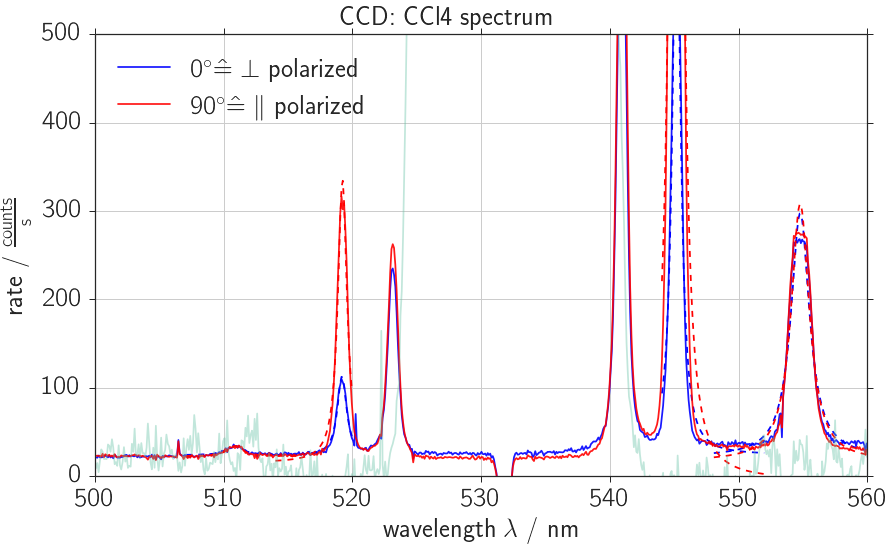

In [15]:
As = []
x0s = []
corr0 = np.load(npy_dir + 'ccd_corr0.npy') # Correction factor for polarization
corr90 = np.load(npy_dir + 'ccd_corr90.npy') # Correction factor for polarization
rate_bg = np.load(npy_dir + 'ccd_rate_bg.npy')
rate_bg_e = np.load(npy_dir + 'ccd_rate_bg_e.npy')

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: CCl4 spectrum')
    
suffixes = ['l2_pol0', 'l2_pol90', 'nol2_pol0', 'nol2_pol90']
suffixes = ['l2_pol0', 'l2_pol90']
labels = ['$0^\circ \hat{=} \perp$ polarized', '$90^\circ \hat{=} \parallel$ polarized']

for i, suffix, label in zip(range(len(labels)), suffixes, labels):
    filename = "ccd_ccl4_" + suffix
    t, avg = t_avg(filename)
     
    # Data
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    y = y / t - rate_bg
    y_e = y_e / t - rate_bg_e
    
    # Correction for polarization
    if suffix[-2:] == '90':
        corr = corr90
    else:
        corr = corr0
    y = corr * y
    y_e = corr * y_e  

    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(5):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        #print(x[out], y[out])
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)

    # Peak fit
    # Peaks: Stokes 1 - 3, Anti-Stokes 1, 2
    x_ranges = [[544, 552],
                [548, 560], 
                [575, 585], 
                [514, 520], 
                [507, 516]]
    p0s = np.array([[546, 0.2, 2000, 0],
                    [555, 0.2, 400, 0], 
                    [579, 0.2, 60, 0], 
                    [519, 0.2, 200, 0], 
                    [511, 0.2, 30, 0]])
    for x_range, p0 in zip(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        ax.plot(x_fit, fit_peak, "--", c=colors[i])
        x0s.append(uc.ufloat(c1[0].n, c1[1].n))
        As.append(c1[2])
    
# display notch filter in order to identify its effects
x_notch = np.load("npy/"+filename+"_lamb.npy")
notch = np.load("npy/ccd_notch.npy")
ax.plot(x_notch, notch * 0.03, "-", alpha = 0.4)

ax.set_xlim(xlim_global)
#ax.set_xlim(570, 590)
ax.set_xlim(500, 560)
ax.set_ylim(0, 500)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_ccl4_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

Because of the notch filter, we cannot analyse the first two raman lines closer to the laser peak ($\Delta \nu = (218, 314)$ cm$^{-1}$). It is not quite clear what 0 or 90 degrees polarization is supposed to mean. 
Our interpretation is: 0 degrees corresponds to perpendicular polarization, 90 to parallel. 
The resulting degree of polarization for $\Delta \nu = 450$ cm$^{-1}$ (lit: 459) is much higher than the lit value (our: 0.29, lit: 0.02). Since this Raman line corresponds to a totally symmetric vibrational mode, one would even expect $\rho$ to be zero. 

Lit: 

https://books.google.de/books?id=PAoVdNiHUwEC&pg=SA3-PA51&dq=raman+spectroscopy+depolarization+ccl4&hl=en&sa=X&ei=PYIqVduMDsPfPYCEgdAM&redir_esc=y#v=onepage&q=raman%20spectroscopy%20depolarization%20ccl4&f=false

https://books.google.de/books?id=f_sJ8CGfetYC&pg=PA129&dq=raman+spectroscopy+depolarization+ccl4&hl=en&sa=X&ei=PYIqVduMDsPfPYCEgdAM&redir_esc=y#v=onepage&q=raman%20spectroscopy%20depolarization%20ccl4&f=false

In [16]:
lamb_all = np.array(x0s).reshape(2, 5)

d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.mean(lamb_all, 0) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

I_s = np.array(As).reshape(2, 5) 
rho = I_s[0] / I_s[1]
dnu, I_s, rho

(array([-453.2335635910336+/-28.351823748169924,
        -770.9954166957244+/-33.82834236792937,
        -1529.5279938410843+/-38.545083592639735,
        463.75376473133025+/-28.456753696585018,
        776.9542713526446+/-32.776058963953226], dtype=object),
 array([[790.4483110927059+/-1.2171579371999663,
         752.4296401480873+/-2.100443846561559,
         107.0155546925768+/-3.1861704502028543,
         123.24183478704568+/-1.258301953622521,
         24.00136206229718+/-1.8266367867530247],
        [2760.4786686534394+/-1.161678501236784,
         787.1476557377199+/-1.7593193818149702,
         72.05551974478144+/-2.7593561984518717,
         429.9156096665213+/-1.2187914733433218,
         26.946571089535684+/-1.7617553436254025]], dtype=object),
 array([0.2863446546675495+/-0.0004570923218495994,
        0.9558938969879868+/-0.003418335931113351,
        1.4851819134970201+/-0.07204167182868354,
        0.2866651780395748+/-0.0030375897439170645,
        0.8907018997907962+